# E06. 영화리뷰 텍스트 감성분석하기

## 데이터 로드

In [1]:
import pandas as pd

train_data = pd.read_table('~/aiffel/E06/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/E06/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


## 단어장 생성

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import numpy as np
import tensorflow as tf
import os

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    x_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_train.append(temp_X)

    x_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_test.append(temp_X)
    
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))
        
    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

>vocab 변수에 pad, bos unk, unused를 모두 채워넣는다. 바로 하단 함수선언에서도 최빈수를 제외한 모든 단어에 unk을 넣기 위해 else에 unk을 채워넣었다.

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

##### ↑ 이코드 솔직히 왜있는지 모르겠다. 안 쓴 것 같다.

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

## max_len 구하기

In [6]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


>이 부분을 아예 안넣었었다. 훈련데이터 중 적절한 최대 길이값을 구해보는 코드이다.

## padding 추가

In [7]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)


>이것도 빼먹었었다. 길이가 짧은 문장들의 '앞'에 padding을 채워넣는다.

## 모델 학습 시작

### 1. RNN

In [8]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [9]:
# validation set 10000건 분리
x_val = x_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지 10000건
partial_x_train = x_train[20000:]
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


>처음에 **단어장==훈련데이터**라고 생각해서 전체 데이터셋이 1만개라고 생각했다. 그래서 validation을 너무 작게 잡았다. 심지어 validation이 뭐하는 건지도 몰랐다. 물론 선생님들(후술예정)이 다 알려주셨다.

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
247/247 [==============================] - 5s 7ms/step - loss: 0.4998 - accuracy: 0.7818 - val_loss: 0.3673 - val_accuracy: 0.8423
Epoch 2/4
247/247 [==============================] - 1s 6ms/step - loss: 0.3422 - accuracy: 0.8563 - val_loss: 0.3491 - val_accuracy: 0.8496
Epoch 3/4
247/247 [==============================] - 1s 5ms/step - loss: 0.3174 - accuracy: 0.8686 - val_loss: 0.3463 - val_accuracy: 0.8516
Epoch 4/4
247/247 [==============================] - 1s 5ms/step - loss: 0.3058 - accuracy: 0.8737 - val_loss: 0.3460 - val_accuracy: 0.8515


In [11]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3553 - accuracy: 0.8466
[0.3552752137184143, 0.8466342687606812]


In [12]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


#### 1.1. 결과 시각화 및 분석

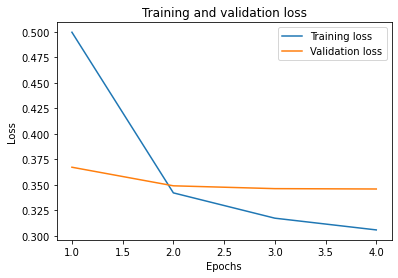

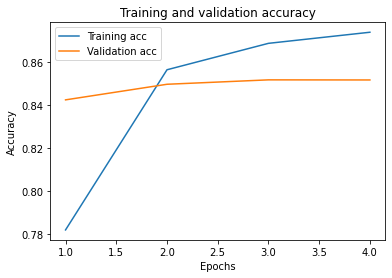

In [13]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

>번거롭게 하지말고 색,형태 인자를 지워버리면 알아서 다른색 선으로 디폴트 세팅된다고 알려주셨다.

### 2. 1-D CNN

In [14]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

>model 변수를 그대로 사용하면 안되므로 2를 붙여주자. 후에 반복되는 모든 변수들에도 적용해주자. 덮어씌워져서 결과가 다 똑같이 나오고 나는 그 원인을 몰랐다. 감사합니다 선생님들

In [15]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
247/247 [==============================] - 3s 6ms/step - loss: 0.4794 - accuracy: 0.7631 - val_loss: 0.3526 - val_accuracy: 0.8465
Epoch 2/4
247/247 [==============================] - 1s 5ms/step - loss: 0.3212 - accuracy: 0.8640 - val_loss: 0.3371 - val_accuracy: 0.8537
Epoch 3/4
247/247 [==============================] - 1s 5ms/step - loss: 0.2813 - accuracy: 0.8847 - val_loss: 0.3374 - val_accuracy: 0.8561
Epoch 4/4
247/247 [==============================] - 1s 5ms/step - loss: 0.2457 - accuracy: 0.9024 - val_loss: 0.3442 - val_accuracy: 0.8544


#### 2.1. 결과 시각화 및 분석

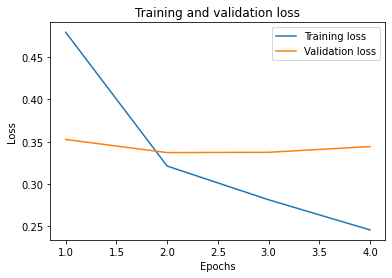

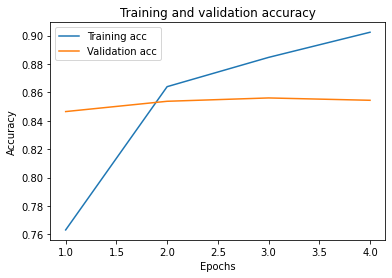

In [16]:
history_dict2 = history2.history

import matplotlib.pyplot as plt

acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 3. GlobalMaxPooling Layer

In [17]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [18]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
247/247 [==============================] - 1s 4ms/step - loss: 0.5712 - accuracy: 0.7754 - val_loss: 0.4144 - val_accuracy: 0.8241
Epoch 2/4
247/247 [==============================] - 1s 3ms/step - loss: 0.3721 - accuracy: 0.8410 - val_loss: 0.3589 - val_accuracy: 0.8396
Epoch 3/4
247/247 [==============================] - 1s 4ms/step - loss: 0.3251 - accuracy: 0.8630 - val_loss: 0.3478 - val_accuracy: 0.8449
Epoch 4/4
247/247 [==============================] - 1s 3ms/step - loss: 0.2985 - accuracy: 0.8760 - val_loss: 0.3482 - val_accuracy: 0.8462


#### 3.1.결과 시각화 및 분석

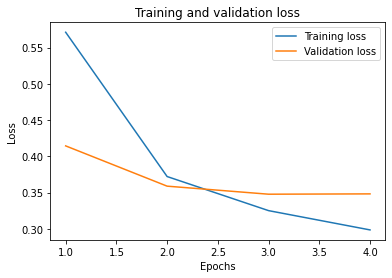

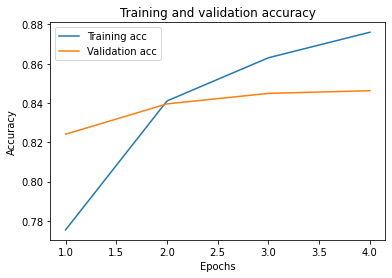

In [19]:
history_dict3 = history3.history

import matplotlib.pyplot as plt

acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 한국어 Word2Vec을 통한 성능 개선 시도

### 임베드 로드
>gensim 모듈의 버전 맞춰주는 법 pip install --upgrade gensim x.x.x <br><br> 지금의 절차는 내가 학습한 임베딩 레이어를 추출해서 유효성을 한번 검증해보는 과정. 물론 쓰레기다.

In [20]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [21]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/E06/sentiment_classification/data/self_korean.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [22]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['이별']
vector

array([-0.01196135,  0.12002622, -0.12325844, -0.17408733, -0.14172286,
       -0.09818792,  0.12487271, -0.16413985, -0.18414907, -0.0936883 ,
       -0.09712256,  0.10928526, -0.15234452, -0.08242277, -0.11321434,
        0.08887289], dtype=float32)

In [23]:
word_vectors.similar_by_word("이별")

[('군더더기', 0.9736173152923584),
 ('그리움', 0.973439633846283),
 ('독도', 0.972589910030365),
 ('각지', 0.9718918800354004),
 ('펑펑', 0.9714186191558838),
 ('브라질', 0.9709688425064087),
 ('슬프', 0.9706728458404541),
 ('곁', 0.9699083566665649),
 ('과언', 0.9696643948554993),
 ('넘사벽', 0.9692463278770447)]

##### ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ너무웃기다 이거

In [25]:
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/E06/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)
vector = word2vec["이별"]

/tmp/ipykernel_682/393012009.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec["이별"]


>word2vec korean 임베딩레이어 가져오기

In [26]:
vector

array([-5.53004920e-01, -5.00180483e-01,  7.44704902e-01,  1.25055504e-03,
        2.89087266e-01,  1.04152016e-01,  3.08591753e-01,  1.47393763e+00,
        7.08666220e-02,  6.31029427e-01, -7.18486533e-02,  1.12189651e+00,
        8.92372370e-01,  1.26223791e+00,  1.44456718e-02,  1.74129218e-01,
       -2.19788849e-01,  1.01980297e-02,  6.70179307e-01,  6.15928233e-01,
       -1.34833872e-01, -2.13126615e-01, -5.22079408e-01, -1.09120317e-01,
        8.61766040e-01, -1.19951749e+00, -1.89669877e-01,  4.19502169e-01,
       -7.01889753e-01,  9.40364599e-03,  1.42930973e+00, -3.14639360e-01,
        1.21137857e+00,  7.49340933e-03,  8.86065602e-01,  5.28543405e-02,
       -6.61643147e-01,  2.55253106e-01, -2.99260557e-01,  4.74507362e-01,
       -9.78151441e-01,  2.68545777e-01, -3.71751860e-02, -1.32945311e+00,
       -7.63620555e-01, -2.95487344e-01,  9.94503051e-02,  1.55709043e-01,
       -2.44340580e-02,  4.25479919e-01,  1.18787432e+00,  3.47999513e-01,
        6.41400635e-01, -

In [29]:
word2vec.similar_by_word("이별")

/tmp/ipykernel_682/1195740980.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("이별")


[('헤어지', 0.6900225877761841),
 ('슬픔', 0.6873862147331238),
 ('추억', 0.6457439661026001),
 ('슬프', 0.6412862539291382),
 ('재회', 0.6345380544662476),
 ('사랑', 0.6334798336029053),
 ('첫사랑', 0.6128619909286499),
 ('고독', 0.6117805242538452),
 ('절망', 0.5997450947761536),
 ('작별', 0.5857374668121338)]

## 임베딩

In [40]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_682/1196876861.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_682/1196876861.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


## 임베딩을 통한 학습 시도

In [41]:
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model4.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model4.add(tf.keras.layers.Dense(8, activation='relu'))
model4.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [42]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model4.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
247/247 [==============================] - 3s 8ms/step - loss: 0.4425 - accuracy: 0.8091 - val_loss: 0.3502 - val_accuracy: 0.8510
Epoch 2/4
247/247 [==============================] - 2s 7ms/step - loss: 0.3203 - accuracy: 0.8648 - val_loss: 0.3366 - val_accuracy: 0.8570
Epoch 3/4
247/247 [==============================] - 2s 7ms/step - loss: 0.2873 - accuracy: 0.8797 - val_loss: 0.3385 - val_accuracy: 0.8569
Epoch 4/4
247/247 [==============================] - 2s 7ms/step - loss: 0.2604 - accuracy: 0.8925 - val_loss: 0.3512 - val_accuracy: 0.8561


In [43]:
results = model4.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3619 - accuracy: 0.8510
[0.36194804310798645, 0.850967288017273]


##### 근데 생각보다 뭐 다이나믹한 성능향상이 있진 않았다.

In [44]:
history_dict4 = history4.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


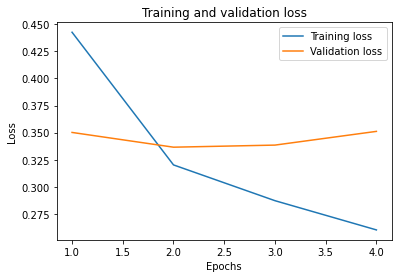

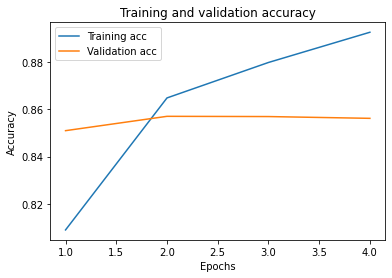

In [45]:
import matplotlib.pyplot as plt

acc = history_dict4['accuracy']
val_acc = history_dict4['val_accuracy']
loss = history_dict4['loss']
val_loss = history_dict4['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고

## ?

**데이터 전처리 과정부터 단어장 형성 및 토큰화, 학습 방법이나 절차 임베딩에 대한 개념 등 하나도 이해를 못한채로 시작했다. 이해가 전혀 반영되지 않았으니 그나마 복붙한 코드들도 모두 순서가 뒤죽박죽이였고, 에러만 반복되면서 진도가 나가지 않았다. 이번 노드는 정말 아이펠 전우님들(?)이 아니었다면 미완성인 채로 제출했을 것이다.**

## Supporters

**정말 다행이었던 것은 내 주변에 아이펠 전우님들이 나의 진행상황을 염려하여 찾아와주셨다는 점이다. 사실 슬슬 생각하는 것도 한계에 부치기 시작해서 물어봐야겠다고 생각은 하고 있었지만 어디서부터 엇나간 것인지 전혀 알지 못해서 질문조차 정리하지 못하고 있던 상태였다. 현동님이 먼저 어떻게 되가시는지 여쭤봐주신 것을 시작으로 채은님과 진환님까지 추가로 달라붙어 이번 노드의 머리부터 발끝까지 과외를 해주셨다. 이렇게 감사할 수가...<br><br>
세 명의 선생님이 코드를 일일히 다 봐주시면서 어떻게 동작되고 어떤 코드가 어떤 절차에 해당하는지, 토큰화하여 단어장을 만들고 데이터를 학습하고, 그동안 모르고 그냥 지나쳤던 validation의 개념 등등 와주신 김에 아주 속시원하게 여쭤봤고 너무 친절하고 상세하고 정확하게 답변을 해주셨다. 덕분에 이 짧은 회고를 남기는 지금은 NLP모델의 기본적인 동작구조와 더 디테일한 코드들의 의미, 등등 많은 것을 어느정도 이해하고 노드를 마치는 것 같다. 사실 이번 노드는 세 분이 만들어 제출하시는 것이나 다름이 없지 않을까..ㅋㅋㅋ<br>
별도의 레퍼런스는 없었다. 어차피 다 해주신 것이기 때문에... 아예 변수 어디를 고쳐야하는지(심지어 왜 고쳐야하는지)까지 다 알려주셨다. 행복한 하루다. 굳이 따지자면 세 분이 나의 스승이자 레퍼랄까. 알려주신 내용들을 모두 기록하려고 다시 훑어보기엔 빨리 제출하고 싶어서 생각나는 대로만 코멘트를 남겼다. 솔직히 지적받은 부분들 다 까먹기도 했고. 이해한 것으로 만족한다.**